# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("diabetes.csv")
# Print shape of dataset
print(df.shape)

(768, 9)


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [2]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

In [3]:
features_with_na

[]

* **There are no null values in the dataset**

### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [4]:
df.duplicated().sum()

np.int64(0)

* **No Duplicates in the dataset**

### Fixing Columns with 0 as Values

In [5]:
(df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

## **Insight**
Glucose, BloodPressure, SkinThickness, Insulin, BMI should not be 0

In [6]:
# List of columns where 0 is medically invalid
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Drop rows where any of these columns have 0
df_cleaned = df[(df[invalid_zero_cols] != 0).all(axis=1)]


Rows with 0 values in 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', or 'BMI'
were dropped because such values are physiologically impossible or clinically implausible.
These zero entries likely represent missing or incorrectly recorded data. Retaining them
could distort model training and lead to misleading predictions in a medical context where
accuracy is critical. Dropping these rows ensures cleaner, more reliable data for analysis.

In [7]:
df_cleaned.shape

(392, 9)

# Feature Engineering

In [8]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Type of Features

**Numeric Features**

In [9]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 9


**Categorical Features**

In [10]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 0


**Discrete features**

In [11]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 2


**Continues Features**

In [12]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 7


### Split X and Y

In [13]:
X = df_cleaned.drop('Outcome', axis=1)
y = df_cleaned['Outcome']

In [14]:
y.head()

3     0
4     1
6     1
8     1
13    1
Name: Outcome, dtype: int64

## Feature Transformation

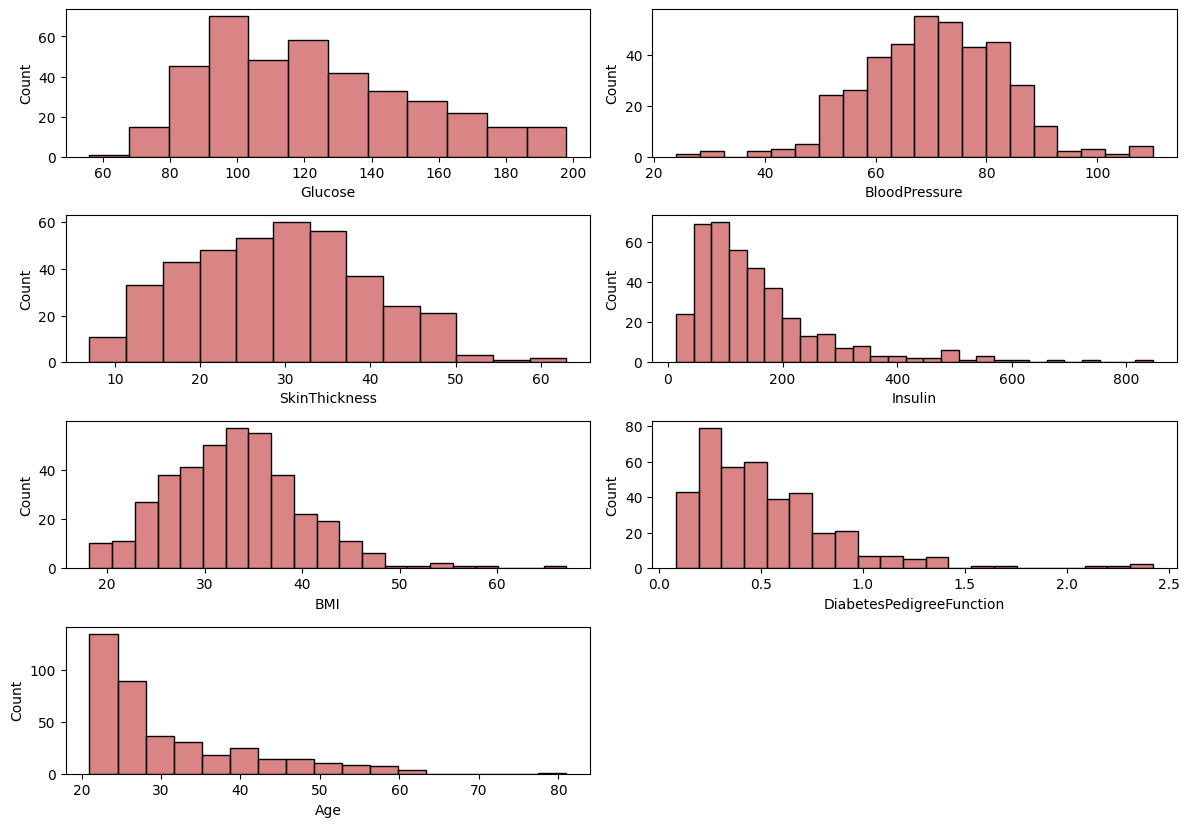

In [15]:
# distribution of data before scaling
plt.figure(figsize=(12, 10))
for i, col in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 
                         'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']):
    plt.subplot(5, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* BloodPressure, Insulin, DiabetesPedigreeFunction, Age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

In [16]:
# Check Skewness
X[continuous_features].skew(axis=0, skipna=True)

Glucose                     0.517850
BloodPressure              -0.087516
SkinThickness               0.209311
Insulin                     2.165116
BMI                         0.663485
DiabetesPedigreeFunction    1.959101
Age                         1.403607
dtype: float64

| Feature                      | Skewness | Interpretation           | Action           |
| ---------------------------- | -------- | ------------------------ | ---------------- |
| **Glucose**                  | 0.52     | Mild/moderate skew       | Optional         |
| **BloodPressure**            | -0.09    | Low skew                 | No transform     |
| **SkinThickness**            | 0.21     | Low skew                 | No transform     |
| **Insulin**                  | 2.17     | Highly positively skewed | Transform needed |
| **BMI**                      | 0.66     | Moderate skew            | Optional         |
| **DiabetesPedigreeFunction** | 1.96     | Highly positively skewed | Transform needed |
| **Age**                      | 1.40     | Highly positively skewed | Transform needed |


## Apply Power Transformer

In [17]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['Insulin', 'DiabetesPedigreeFunction', 'Age']
X_copy = pt.fit_transform(X[transform_features])

In [18]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

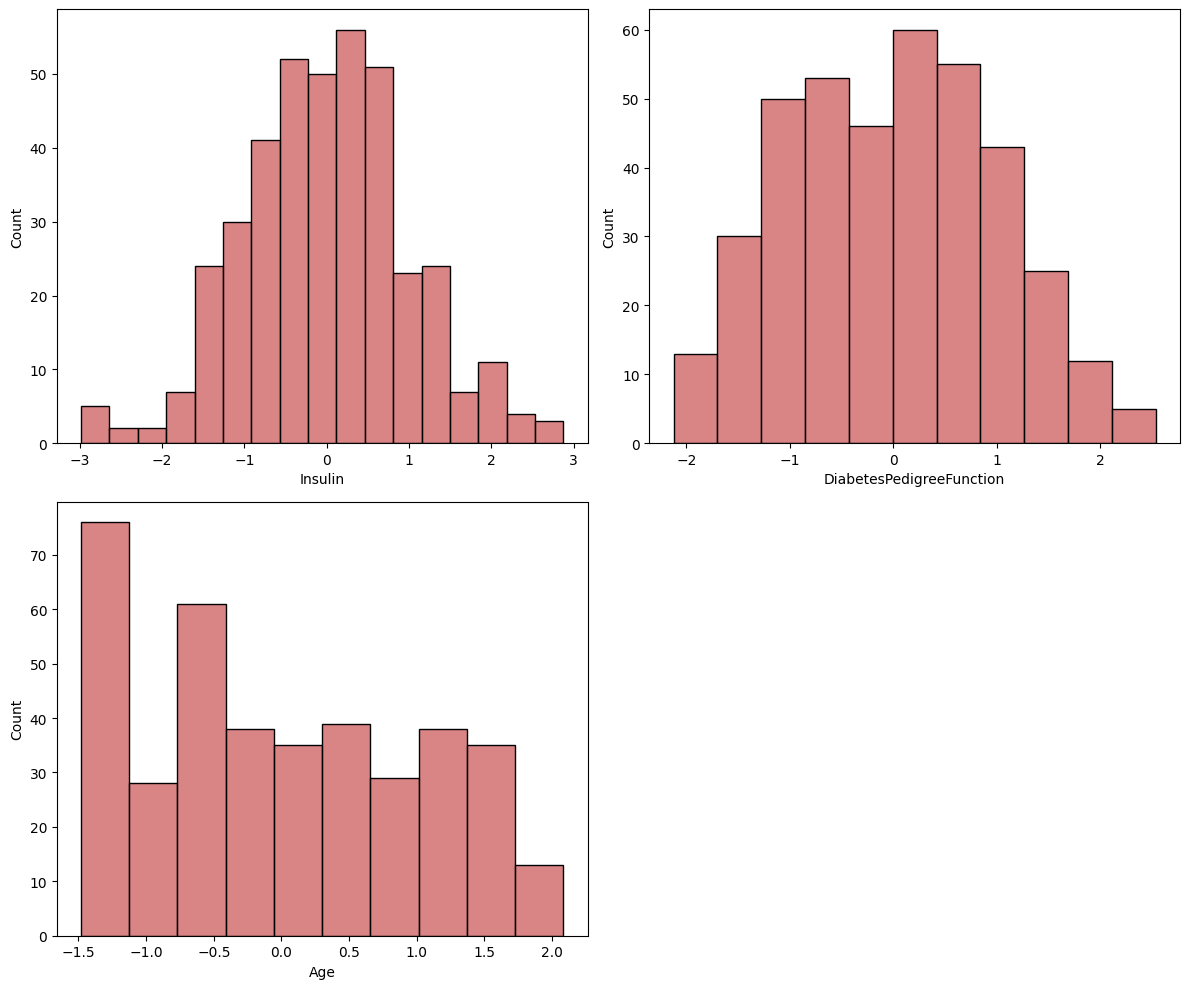

In [19]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(transform_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

**Checking Skewness**

In [20]:
X_copy.skew(axis=0, skipna=True)

Insulin                     0.001513
DiabetesPedigreeFunction    0.080712
Age                         0.214510
dtype: float64

## Feature Scaling

In [21]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [22]:
num_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### **Preprocessing using Column Transformer**

In [23]:
# Create Column Transformer with 3 types of transformers
transform_columns = ['Insulin', 'DiabetesPedigreeFunction', 'Age']

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [24]:
X = preprocessor.fit_transform(X)

In [25]:
X

array([[-0.4025412 , -1.47724157, -1.48116989, ..., -0.710421  ,
        -1.03187632, -0.9682991 ],
       [ 0.43688655,  2.48452369,  0.63429686, ...,  1.42673006,
         5.11511079,  0.2095853 ],
       [-0.49657661, -0.95074866, -0.28526455, ..., -0.29723846,
        -0.79712575, -0.47751393],
       ...,
       [-2.8137547 ,  0.96910858, -1.18384542, ..., -0.66767798,
         0.70411863, -0.87014206],
       [ 0.53796052, -1.448864  ,  1.86948523, ..., -0.02653266,
        -1.0202837 ,  3.15429628],
       [-0.15142492, -0.96857536,  0.30980968, ..., -0.9811268 ,
        -0.80582021, -0.0848858 ]], shape=(392, 11))

## Solving Imbalance

In [26]:
from imblearn.combine import  SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Train Test Split


In [27]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((256, 11), (65, 11))

## Model Building

In [28]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [30]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [31]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

## Model Training

In [32]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9538
- F1 score: 0.9565
- Precision: 0.9429
- Recall: 0.9706
- Roc Auc Score: 0.9530


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9385
- F1 score: 0.9412
- Precision: 0.9412
- Recall: 0.9412
- Roc Auc Score: 0.9383


Gradient Boosting
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9692
- F1 score: 0.9714
- Precision: 0.9444
- Recall: 1.0000
- Roc Auc Score: 0.9677


Logistic Regression
Model performance for Training 

In [33]:
base_model_report

,Model Name,Accuracy
2,Gradient Boosting,0.969231
7,Support Vector Classifier,0.969231
4,K-Neighbors Classifier,0.969231
8,AdaBoost Classifier,0.969231
0,Random Forest,0.953846
6,CatBoosting Classifier,0.953846
1,Decision Tree,0.938462
5,XGBClassifier,0.923077
3,Logistic Regression,0.907692


## Hyper Parameter Tuning

**Define the parameter distribution**

In [34]:
#Initialize few parameter for Hyperparamter tuning
gboost_params = {
    'max_depth':range(3,5,7),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [35]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("GradientBoost", GradientBoostingClassifier(), gboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

**Create a function for model training and report which can be used in hyperparameter tuning loop**

In [36]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for GradientBoost -------------------
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 3}
---------------- Best Params for RF -------------------
{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 10}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


In [37]:
model_param

{'GradientBoost': {'n_estimators': 200,
  'max_features': 'log2',
  'max_depth': 3},
 'RF': {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 10},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

## Retraining the Model with best Parameters

In [38]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "GradientBoost Classifier": GradientBoostingClassifier(**model_param['GradientBoost']),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9692
- F1 score: 0.9714
- Precision: 0.9444
- Recall: 1.0000
- Roc Auc Score: 0.9677


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9846
- F1 score: 0.9855
- Precision: 0.9714
- Recall: 1.0000
- Roc Auc Score: 0.9839


GradientBoost Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9692
- F1 score: 0.9706
- Precision: 0.9706
- Recall: 0.9706
- Roc Auc Score: 0.9692




In [39]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.984615
0,Random Forest Classifier,0.969231
2,GradientBoost Classifier,0.969231


In [40]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9846
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.99        34

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65



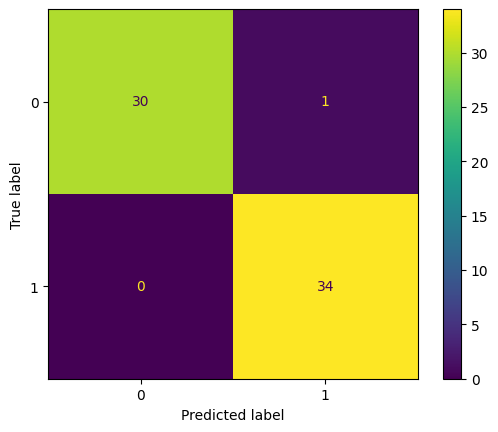

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Best Model is K-Nearest Neighbor(KNN) with Accuracy 98.46%